In [1]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd


In [2]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)

# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        # triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    B, M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_ab, stride_am, stride_ak,
    stride_bb, stride_bk, stride_bn,
    stride_cb, stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    offs_b = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_b * stride_ab + offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_b * stride_bb + offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b, out_dtype=tl.float32)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.bfloat16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + (offs_b * stride_cb + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :])
    c_mask = (offs_b < B) & (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


In [3]:
def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[0] == b.shape[0], "Incompatible dimensions"
    assert a.shape[2] == b.shape[1], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    B, M, K = a.shape
    B, K, N = b.shape

    # Allocates output.
    c = torch.empty((B, M, N), device=a.device, dtype=a.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        B,
    )
    matmul_kernel[grid](
        a, b, c,
        B, M, N, K,
        a.stride(0), a.stride(1), a.stride(2),
        b.stride(0), b.stride(1), b.stride(2),
        c.stride(0), c.stride(1), c.stride(2),
        ACTIVATION=activation
    )
    return c


In [4]:
def unit_test():
    torch.manual_seed(0)
    a = torch.randn((4, 512, 512), device='cuda', dtype=torch.bfloat16)
    b = torch.randn((4, 512, 512), device='cuda', dtype=torch.bfloat16)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a, b)
    print(f"triton_output={triton_output}")
    print(f"torch_output={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

unit_test()


triton_output=tensor([[[ 49.0000,  14.9375,   1.0703,  ...,  15.6875, -33.0000, -10.3125],
         [-30.6250,   0.7773,  -4.6875,  ..., -31.5000,  37.5000,  10.2500],
         [-19.6250,   7.4062, -36.5000,  ...,   1.2734,   9.0000,  35.5000],
         ...,
         [-27.5000, -12.1250,  17.8750,  ...,  31.5000,  31.5000,  34.2500],
         [ 16.1250, -15.5625,  -5.5000,  ...,  23.3750,  18.8750, -23.2500],
         [-49.2500,  11.6875,  12.7500,  ...,  48.5000,  25.2500,  50.2500]],

        [[ 41.5000, -32.2500,  15.1250,  ...,  12.5625, -18.7500,   2.2031],
         [-23.7500, -49.5000, -26.1250,  ..., -35.5000,   1.1719, -33.0000],
         [  7.0000,   2.2031,  -6.9062,  ...,  14.6250, -33.2500,  49.7500],
         ...,
         [ 38.0000, -13.3125, -25.6250,  ...,  17.3750, -25.8750,   3.6250],
         [  4.3438,  -2.4375,   9.2500,  ..., -16.5000,   2.6875,   1.2188],
         [-20.2500,  36.2500,  15.8750,  ...,  -9.3125,  10.6875,  43.2500]],

        [[ -3.5781, -22.3750, 

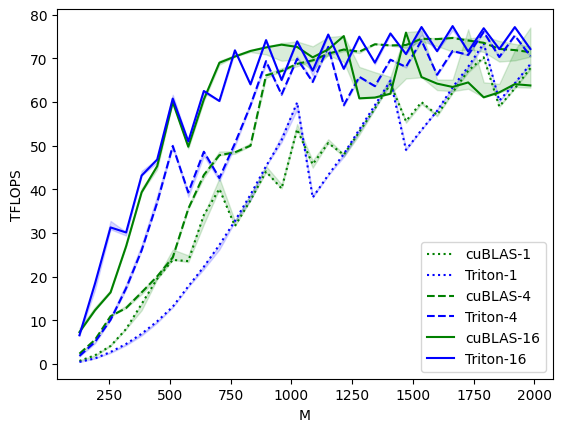

matmul-performance:
         M       N       K   cuBLAS-1   Triton-1   cuBLAS-4   Triton-4  cuBLAS-16  Triton-16
0    128.0   128.0   128.0   0.682667   0.455111   2.340571   1.820444   7.281778   6.553600
1    192.0   192.0   192.0   1.974857   1.256727   5.529600   5.026909  12.288000  18.431999
2    256.0   256.0   256.0   4.096000   2.730667  10.922666  10.082462  16.384000  31.271604
3    320.0   320.0   320.0   8.000000   4.571429  12.800000  17.337567  26.947370  30.117647
4    384.0   384.0   384.0  13.743473   6.912000  16.384000  26.021647  39.321599  43.157854
5    448.0   448.0   448.0  19.512888   9.756444  20.070399  36.971791  45.320259  46.830935
6    512.0   512.0   512.0  23.831273  13.107200  24.385488  49.932191  59.998983  60.787013
7    576.0   576.0   576.0  23.558058  17.773714  35.547429  39.289265  49.766401  50.994790
8    640.0   640.0   640.0  34.133334  22.260869  43.286658  48.617210  60.611328  62.534354
9    704.0   704.0   704.0  40.086588  27.258881  

In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            64 * i for i in range(2, 32)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas-1', 'triton-1', 'cublas-4', 'triton-4', 'cublas-16', 'triton-16'],
        # Label name for the lines
        line_names=["cuBLAS-1", "Triton-1", "cuBLAS-4", "Triton-4", "cuBLAS-16", "Triton-16"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(M, N, K, provider):
    B = int(provider[provider.find('-') + 1:])
    a = torch.randn((B, M, K), device='cuda', dtype=torch.bfloat16)
    b = torch.randn((B, K, N), device='cuda', dtype=torch.bfloat16)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('cublas'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.bmm(a, b), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * B * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)

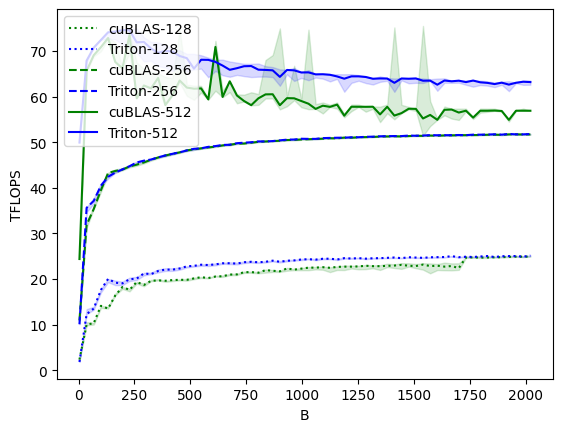

matmul-performance:
         B  cuBLAS-128  Triton-128  cuBLAS-256  Triton-256  cuBLAS-512  Triton-512
0      4.0    2.340571    1.820444   10.922666   10.082462   24.385488   49.932191
1     36.0   10.007618   12.288000   31.882377   35.612014   65.664252   67.893412
2     68.0   10.315852   13.524880   35.368635   37.137068   69.092221   70.737270
3    100.0   14.124138   17.617204   39.479519   40.469935   70.849731   72.415471
4    132.0   13.516800   20.024889   43.253761   42.405648   72.848437   74.096376
5    164.0   16.384000   19.192685   43.690665   43.338323   67.596879   74.251498
6    196.0   18.245818   19.043819   43.989916   44.037047   66.211631   74.570479
7    228.0   17.620528   19.956204   44.695332   44.737148   73.516397   74.524729
8    260.0   19.362909   20.093585   45.077672   45.559787   59.630308   71.896034
9    292.0   18.688000   21.227412   45.563124   45.952901   62.435601   71.987232
10   324.0   19.597291   21.065143   46.160138   46.200942   61.815

In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['B'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            i for i in range(4, 2048, 32)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas-128', 'triton-128', 'cublas-256', 'triton-256', 'cublas-512', 'triton-512'],
        # Label name for the lines
        line_names=["cuBLAS-128", "Triton-128", "cuBLAS-256", "Triton-256", "cuBLAS-512", "Triton-512"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(B, provider):
    M = int(provider[provider.find('-') + 1:])
    K = M
    N = M
    a = torch.randn((B, M, K), device='cuda', dtype=torch.bfloat16)
    b = torch.randn((B, K, N), device='cuda', dtype=torch.bfloat16)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('cublas'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.bmm(a, b), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * B * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)

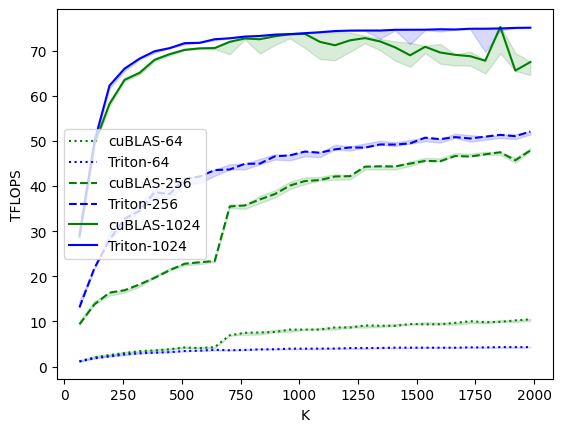

matmul-performance:
         K  cuBLAS-64  Triton-64  cuBLAS-256  Triton-256  cuBLAS-1024  Triton-1024
0     64.0   1.170286   1.139756    9.362286   13.107200    28.728108    29.127110
1    128.0   2.048000   1.820444   13.797053   21.845333    49.344753    49.932191
2    192.0   2.545087   2.234182   16.383999   28.086857    58.254222    62.291645
3    256.0   2.995932   2.688656   16.912516   32.768000    63.550060    66.052028
4    320.0   3.413333   2.925714   18.204444   34.492633    65.128943    68.262499
5    384.0   3.582834   3.072000   19.660800   38.657179    68.015742    69.905066
6    448.0   3.822933   3.185778   21.345059   38.229332    69.245585    70.577232
7    512.0   4.223871   3.449263   22.795130   41.579223    70.197556    71.697502
8    576.0   4.096000   3.510857   23.123269   42.130285    70.541907    71.765659
9    640.0   4.311579   3.723636   23.405714   43.554559    70.611180    72.565816
10   704.0   6.931692   3.604480   35.490265   43.690666    71.9806

In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            i for i in range(64, 2048, 64)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas-64', 'triton-64', 'cublas-256', 'triton-256', 'cublas-1024', 'triton-1024'],
        # Label name for the lines
        line_names=["cuBLAS-64", "Triton-64", "cuBLAS-256", "Triton-256", "cuBLAS-1024", "Triton-1024"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(K, provider):
    B = 16
    M = int(provider[provider.find('-') + 1:])
    N = M
    a = torch.randn((B, M, K), device='cuda', dtype=torch.bfloat16)
    b = torch.randn((B, K, N), device='cuda', dtype=torch.bfloat16)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('cublas'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.bmm(a, b), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * B * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)

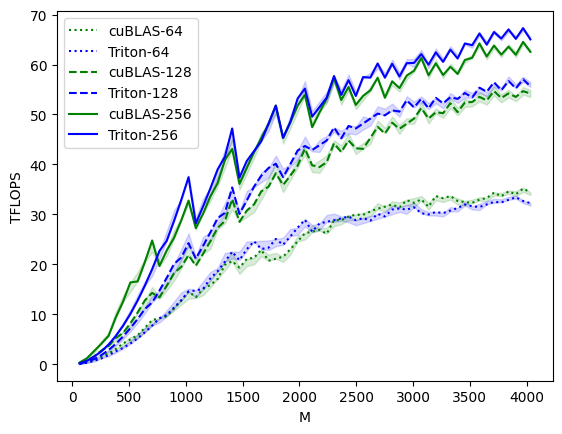

matmul-performance:
         M       N  cuBLAS-64  Triton-64  cuBLAS-128  Triton-128  cuBLAS-256  Triton-256
0     64.0    64.0   0.102400   0.073636    0.204800    0.126517    0.341333    0.173836
1    128.0   128.0   0.409600   0.301315    0.757642    0.500275    1.170286    0.682667
2    192.0   192.0   0.819200   0.658286    1.536000    1.024000    2.633143    1.536000
3    256.0   256.0   1.638400   1.170286    2.730667    1.820444    4.096000    2.570039
4    320.0   320.0   2.133333   1.828571    3.657143    2.844444    5.688889    3.938462
5    384.0   384.0   3.072000   2.598344    5.266286    4.096000    9.399586    5.671385
6    448.0   448.0   4.181333   3.276800    6.272000    5.575111   12.544000    7.719385
7    512.0   512.0   4.969554   4.152776    8.192000    7.231559   16.384000   10.082462
8    576.0   576.0   5.807895   5.184000   10.368000    9.058731   16.588800   12.760616
9    640.0   640.0   7.314286   6.400000   12.800000   11.070270   20.480001   15.753846
1

In [8]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            i for i in range(64, 4096, 64)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas-64', 'triton-64', 'cublas-128', 'triton-128', 'cublas-256', 'triton-256'],
        # Label name for the lines
        line_names=["cuBLAS-64", "Triton-64", "cuBLAS-128", "Triton-128", "cuBLAS-256", "Triton-256"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(M, N, provider):
    B = 1
    K = int(provider[provider.find('-') + 1:])
    a = torch.randn((B, M, K), device='cuda', dtype=torch.bfloat16)
    b = torch.randn((B, K, N), device='cuda', dtype=torch.bfloat16)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('cublas'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.bmm(a, b), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * B * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)